In [3]:
portfolio_sd_t <- function(sd, cov, weight){
  stopifnot(length(sd) > 1, is.matrix(cov), length(sd) == length(weight))
  for(i in 1:(length(sd)-1)){
    for(j in (i+1):length(sd)){
      n <- sum(weight[i:length(sd)]^2*sd[i:length(sd)]^2)
      m <- sum(2*weight[i]*weight[j]*cov[i,j])
      sd <- sqrt(sum(weight[i:length(sd)]^2*sd[i:length(sd)]^2+
                       2*weight[i]*weight[j]*cov[i,j]))
      return(sd)
    }
  }
}
portfolio_return <- function(returns, weight){
  if(!is.vector(returns) > 1){
    mean <- apply(returns,2,mean)
  } else{
    if(is.vector(returns)){
      mean <- returns
    }
  }
  total_return <- sum(weight*mean)
  return(total_return)
}

In [4]:
options(warn = -1, verbose = F)
library(dplyr)
library(tidyr)
library(ggplot2)
library(tidyquant)
library(pracma)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: lubridate


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: PerformanceAnalytics

Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'xts'


The following objects are masked from 'package:dplyr':

    first, last



Attaching package: 'PerformanceAnalytics'


The following object is masked from 'package:graphics':

    legend


Loading required package: quantmod

Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Version 0.4-0 included new d

In [66]:
#Estipule os parâmetros para calcular os desvios-padrão e os retornos médios (diários e anuais)
acoes <- c("B3SA3.SA","ITUB4.SA","PETR4.SA","BBDC4.SA","PETR3.SA","ABEV3.SA","MGLU3.SA","BBAS3.SA")
retornos_d <- tq_get(acoes, from = Sys.Date()-365) %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun= periodReturn, period = "daily")
retornos_a <- tq_get(acoes, from = Sys.Date()-365*5) %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun= periodReturn, period = "yearly") %>%
  mutate(year = year(date)) %>%
  group_by(year,symbol) %>%
  summarise(yearly.returns) %>%
  spread(key = "symbol", value = "yearly.returns")
sd_d <- retornos_d %>%
  group_by(symbol) %>%
  summarise(sd = sd(daily.returns)) %>%
  spread(key = "symbol", value = sd)
cov <- retornos_d %>%
  spread(key = "symbol", value = daily.returns)
cov$date <- NULL
cov <- cov(cov)

`summarise()` regrouping output by 'year' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [67]:
#Nº de simulações de carteiras a se fazer
n_sim <- 10000
pesos <- matrix(0,length(acoes),n_sim)
pesos <- apply(pesos,2,rexp,length(acoes))
for(i in 1:ncol(pesos)){
  pesos[,i] <- pesos[,i]/sum(pesos[,i])
}

In [68]:
time <- system.time({
    riscos <- apply(pesos, 2, portfolio_sd_t, sd = sd_d, cov = cov)*sqrt(252)
    retornos <- apply(pesos, 2, portfolio_return, returns = retornos_a[,2:ncol(retornos_a)])
})

In [69]:
#Sharpe
tx_livre_risco <- 0.0225
data <- data.frame(riscos = riscos, retornos = retornos, sharpe = (retornos-tx_livre_risco)/riscos)

In [70]:
#Retorno médio das ações
retorno_med <- retornos_a %>%
  gather(key = "symbol", value = "return", -year) %>%
  group_by(symbol) %>%
  summarise(media = mean(return)) %>%
  spread(key = "symbol", value = "media")

`summarise()` ungrouping output (override with `.groups` argument)



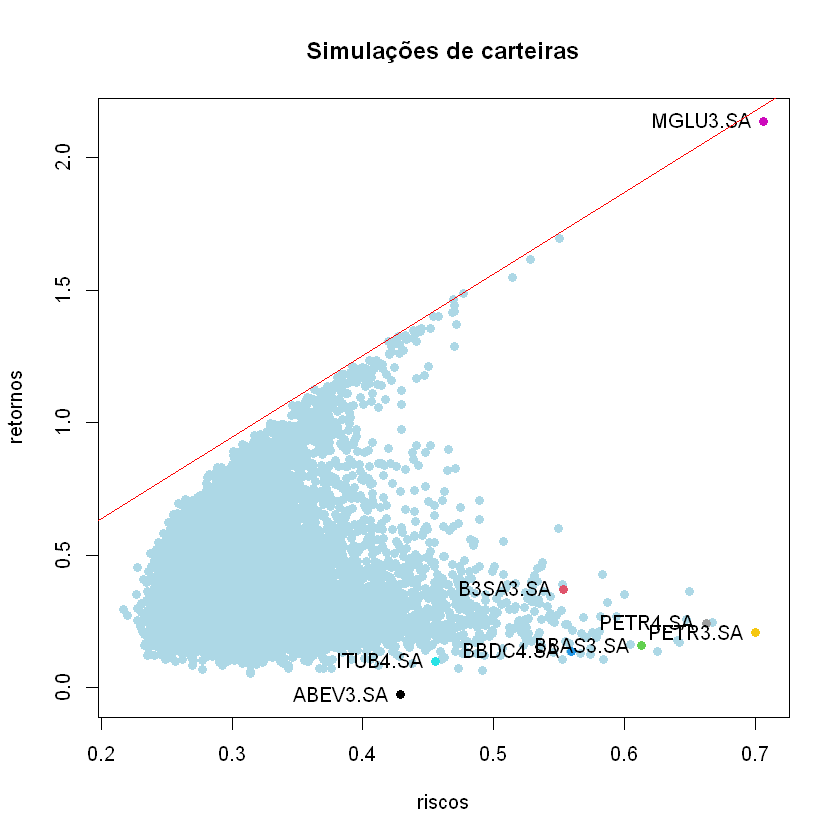

In [71]:
plot(riscos, retornos, pch = 16, col = "lightblue",xlim = c(min(riscos), max(sd_d*sqrt(252))),
    ylim = c(min(retorno_med), max(retorno_med)), main = "Simulações de carteiras")
points(x = sd_d*sqrt(252), y = retorno_med, col = 1:ncol(retorno_med), pch = 16)
text(x = sd_d*sqrt(252), y = retorno_med, labels = colnames(retorno_med), pos = 2)
abline(a = tx_livre_risco, b = max(data$sharpe), col = "red")

In [72]:
max(data$sharpe)

[1] 3.075029

In [77]:
time

   user  system elapsed 
  76.59    0.18   81.38 

## Para encontrar os pesos de carteira de maior sharpe é necessário colar o maior sharpe no ctr+f, ver a linha em que está e dar print na coluna de mesmo número da matriz "pesos"

In [74]:
show(data)

         riscos   retornos     sharpe
1     0.2868197 0.16318779 0.49050952
2     0.2512366 0.37714376 1.41159285
3     0.3232260 0.44115885 1.29525106
4     0.3599986 0.39742320 1.04145733
5     0.2886100 0.46909667 1.54740534
6     0.3097586 0.63039388 1.96247596
7     0.3242415 0.25453379 0.71562019
8     0.3726813 0.24700347 0.60240065
9     0.3093826 0.21464918 0.62107301
10    0.2853057 0.17346835 0.52914585
11    0.3150480 0.20281970 0.57235631
12    0.3100403 0.68521485 2.13751171
13    0.2815849 0.40524871 1.35926599
14    0.2652948 0.58500847 2.12031473
15    0.2887250 0.23929257 0.75086186
16    0.3881795 0.22459642 0.52062624
17    0.2721006 0.22293480 0.73662027
18    0.3349221 0.35164639 0.98275504
19    0.3203625 0.21881613 0.61279368
20    0.2907782 0.43882149 1.43174956
21    0.3896578 0.22331018 0.51535003
22    0.3133260 0.31944582 0.94772153
23    0.3577039 0.10103750 0.21956007
24    0.3786532 0.28709715 0.69878484
25    0.3374623 0.43924496 1.23493779
26    0.3306

In [76]:
pesos[,8099]

[1] 0.000374151 0.121440967 0.069451007 0.096199848 0.038665047 0.649039093
[7] 0.001794072 0.023035816

In [75]:
#Os pesos acima equivalem as ações em ordem alfabética
sort(acoes)

[1] "ABEV3.SA" "B3SA3.SA" "BBAS3.SA" "BBDC4.SA" "ITUB4.SA" "MGLU3.SA" "PETR3.SA"
[8] "PETR4.SA"